# Imports

In [1]:
from skimage.transform import resize
import os
from multiprocessing import pool
import sys
import pickle
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import cv2
import torch
import math
import random
from segment_anything import SamPredictor, sam_model_registry, SamAutomaticMaskGenerator

sys.path.append("..")
from functions.preprocess import preprocess_image
from functions.sam_functions import (
    get_logits,
    get_masks,
    multiclass_prob,
    sample_from_class,
    show_mask,
)

In [2]:
os.chdir("/Users/lisa/Documents/Master/sam-lab")
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
MODEL_TYPE = "vit_h"
CHECKPOINT_PATH = "sam_vit_h_4b8939.pth"
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH)
sam.to(device=DEVICE)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

# Load image

In [3]:
os.chdir("/Users/lisa/Documents/Master/sam-lab/ACDC/database/training/patient001")
patient_001 = nib.load("patient001_frame01.nii.gz")
sl = 7  # slice number
after = preprocess_image(
    patient_001, spacing_target=(10, 1.25, 1.25), keep_z_spacing=True
)
image = after[:, :, sl]
patient_001_gt = nib.load("patient001_frame01_gt.nii.gz")
after_gt = preprocess_image(
    patient_001_gt, is_seg=True, spacing_target=(10, 1.25, 1.25), keep_z_spacing=True
)
ground_truth = after_gt[:, :, sl]

In [4]:
# Convert to RGB
image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
# Change pixel values from [-1,1] to [0,255] range, np.uint8 type because SAM only accepts these values for RGB image
image = cv2.normalize(
    image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F
)
image = image.astype(np.uint8)

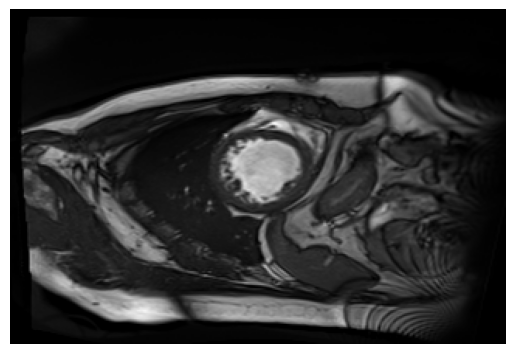

In [6]:
fig, ax = plt.subplots()
ax.imshow(image, cmap="gray")
ax.axis("off")  # Turn off the axes

plt.savefig(
    "/Users/lisa/Documents/Master/sam-lab/Presentations/Images/example_image.png",
    bbox_inches="tight",
    pad_inches=0,
)
plt.show()

# Set Image to Predictor

In [7]:
predictor = SamPredictor(sam)
predictor.set_image(image)

# Make prompt

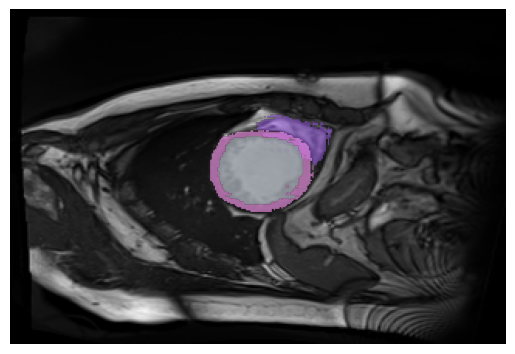

In [18]:
prompts = []
n_points = 50
for label in [1, 2, 3]:
    prompts.append(sample_from_class(ground_truth, label, n_points=n_points))
masks = get_masks(prompts, predictor)
plt.imshow(image)
for mask in masks:
    show_mask(mask, plt.gca(), random_color=True)
plt.axis("off")
plt.savefig(
    "/Users/lisa/Documents/Master/sam-lab/Presentations/Images/example_segmentation.png",
    bbox_inches="tight",
    pad_inches=0,
)
plt.show()

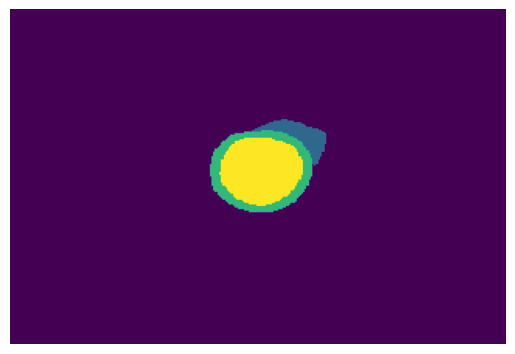

In [9]:
fig, ax = plt.subplots()
ax.imshow(ground_truth)
ax.axis("off")  # Turn off the axes

plt.savefig(
    "/Users/lisa/Documents/Master/sam-lab/Presentations/Images/example_ground_thruth.png",
    bbox_inches="tight",
    pad_inches=0,
)
plt.show()

# Get probabilities from SAM

In [31]:
n_points = 50
prompts = []
for label in [1, 2, 3]:
    prompts.append(sample_from_class(ground_truth, label, n_points=n_points))
logits = get_logits(prompts, predictor)
multi_class = multiclass_prob(logits, hard_labels=True)

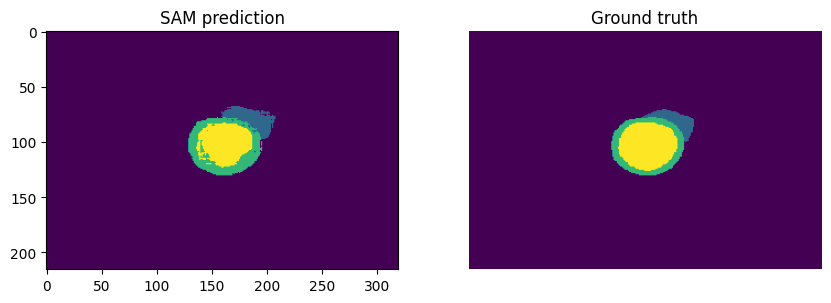

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(multi_class)
axes[0].set_title("SAM prediction")

axes[1].imshow(ground_truth)
axes[1].set_title("Ground truth")
plt.axis("off")
plt.savefig(
    "/Users/lisa/Documents/Master/sam-lab/Presentations/Images/example_comparison.png",
    bbox_inches="tight",
    pad_inches=0,
)
plt.show()